# Food Image Classification for the course _Foundations of Deep Learning_.

Professors:
Paolo Napoletano
Marco Buzzelli

Tutor:
Mirko Agarla

[TODO]
- Introduce the problem you are trying to solve
- Show an analysis of the available data (EDA for images)
- Describe your solution
- Comment positive and negative results of your solution
(rely on quantitative and qualitative observations)
- Describe alternative (possibly failed) experiments

# TRAINING NOTEBOOK

[INSERT DESCRIPTION OF THE NOTEBOOK]

## Install packages

In [1]:
!pip install scikeras
!pip install split-folders # install the package to split the images in TRAIN and TEST folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [2]:
# IMPORT TENSORFLOW/KERAS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator


# TRANSFER LEARNING
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

# SCIKIT-LEARN/SCIKERAS
import sklearn.metrics as metrics
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# IMPORT OTHER MODULES
import os
import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
import splitfolders # needed to split the images in TRAIN and TEST folders
from shutil import copyfile # to import "copyfile"
from matplotlib import pyplot as plt

# CV2
import cv2
from google.colab.patches import cv2_imshow 

In [3]:
# SET RANDOM SEED TO GET, AS MUCH AS POSSIBLE, REPRODUCIBLE RESULTS
# USING NUMPY
from numpy.random import seed
seed(42)

# USING TENSORFLOW: IN ADDITION, TENSORFLOW HAS ITS OWN RANDOM NUMBER
# GENERATOR THAT MUST ALSO BE SEEDED BY CALLING THE SET_RANDOM_SEED()
# FUNCTION IMMEDIATELY AFTER THE NUMPY RANDOM NUMBER GENERATOR
tf.random.set_seed(42)

In [4]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# IMPORT UTILS.PY

# 1.Insert the directory
import sys
sys.path.insert(0,"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food")

# 2.Import your module or file
import utils

In [ ]:
# # TRANSFER THE DATA FROM THE GOOGLE DRIVE FOLDER TO THE VIRTUAL MACHINE

# # The first path is the "data" folder on my Google Drive, and the second one is the destination in my current runtime
# # https://stackoverflow.com/questions/67360001/copy-files-from-a-mounted-google-drive-to-a-local-google-colab-session
# !cp -r /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/Foundation_of_Deep_Learning/Project_Example_Food/ExampleFoodImageDataset /content/ExampleFoodImageDataset

In [6]:
# CONSTANT
# SCALE_PERCENT = 6 # resizing percentage
SEED_VALUE = 42
num_classes = 9 # number of output classes

# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
PREPROCESSED_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"
DIR_TRAIN_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test' # path contenente i sottoinsiemi di train, test

# LOAD THE FOLDERS WHERE THE TRAINING/TESTING/VALIDATION DATA ARE STORED
base_path_train = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/'
base_path_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/'
base_path_val = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/'

In [ ]:
# # REMOVE ANY FOLDER NOT EMPTY IN GOOGLE DRIVE THAT YOU DO NOT NEED
# import shutil

# shutil.rmtree('/content/test')

-----------------------------------

# 5.Model Training
This section deals with the model creation, results and explanation.



> ## 5.1 Data loader



In any deep learning framework, a data loader takes care of (at least) the following tasks:

- Loading input and target data
- Splitting the dataset into mini batches

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(base_path_train,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            # subset='training',
                                                            shuffle=True,
                                                            seed=1)

test_dataset = keras.preprocessing.image_dataset_from_directory(base_path_test,
                                                            image_size=(224,224),
                                                            color_mode='rgb',
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            # subset='validation',
                                                            shuffle=True,
                                                            seed=1)

Found 2004 files belonging to 10 classes.
Found 374 files belonging to 10 classes.


## 5.2 Model architectures

### 5.2.1 Model V01

In [ ]:
# Architecture definition V01
inputs = keras.Input((224, 224, 3)) # 224 rows, 224 columns, 3 RGB channels

x = inputs
# 32 filtri 3x3. Padding: mi dice quanti pixel aggiungere di cornice alla mia 
# immagine prima di fare la convoluzione. Se non fornito, l'output della 
# convoluzione produrrà un immagine un pelo più piccola di quella di partenza 
# spazialmente: nel far scorrere la finestra di convoluzione non riesce a coprire
# l'intorno del pixel di riferimento nell'immagine. Dando "same" il padding
# viene calcolato automaticamente. 
x = keras.layers.Conv2D(32, 3, padding='same')(x)
# Attivazione ReLU: la funzione di attivazione introduce una non linearità.
# Fa si che il calcolo che permette di trasformare i numeri che stanno nell'input
# nei numeri che stanno nell'output non sia semplicemente una combinazione
# lineare dell'input, ma in generale crea un livello di complessità maggiore
# che è quello di costruire delle astrazioni, ovvero permette alla rete neurale
# di dire: ok, adesso ho individuato delle linee di base, ora ci costruisco
# sopra dei ragionamenti più complessi.
# x = keras.layers.Activation('relu')(x)
x = keras.layers.Activation('relu')(x)
# MaxPooling con finestre/windows 3x3 e stride di 3: ciò significa che ogni
# 3x3 valori dell'input li sostituiamo con il suo Max e poi quando spostiamo
# la finestra che esegue questa operazione, la spostiamo di 3 pixels a destra.
# Così facendo non contiamo più volte lo stesso input e in questo caso l'output
# di questo layer sarà per definizione più piccolo spazialmente dell'input.
# E' un tipo di layer che ci serve concettualmente per essere meno dipendenti
# da eventuali piccole variazioni nell'input (se ci sono tralazione dei dati
# di un pixel a destra) il Max Pooling è abbastanza robusto da queste variazioni
# trascendendo di qualche misura da variazioni dei dati. 
# Tra l'altro se lo usiamo con questo stride diminuisce la dimensione dell'input
# e la complessità dei valori che portiamo avanti nella rete neurale. Stiamo
# infatti passando da 224x224x3 valori a 3 numeri. 
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)

# Equivalente del Max Pooling ma in automatico calcola, invece che basarsi su
# una finestra 3x3 utilizza una finestra grande quanto l'intera attivazione
# del layer precedente.
x = keras.layers.GlobalMaxPooling2D()(x)

# Questa softmax prende i due numeri (le due classi specificate) e dà in input
# una funzione che ha lo scopo di produrre una pseudo distrubuzione di 
# probabilità. Si assicura che la somma dei valori (dei due valori nel nostro
# caso), faccia 1, e introduce delle non linearità.
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Con questo comando impacchettiamo tutti i nostri passaggi e diciamo 
# che la mia rete neurale è un modello che parte dalla variabile "inputs" e
# termina con la variabile chiamata "outputs". 
net = keras.Model(inputs, outputs)

In [ ]:
# La compilazione ci serve per definire quali sono le procedure utilizzate 
# durante l'addestramento. La loss in questa esercitazione non è più la differenza
# tra valore di regressione target e quello stimato ma "categorical_crossentropy".
# Per ogni immagine (dato di input) dice: guardiamo la mi ground truth. Quale era
# la classe della mia immagine? Era gatto (prima classe). Andiamo a vedere se
# nel primo dei due valori restituiti dalla rete neurale per quella immagine
# c'è un valore molto alto (idealmente deve essere 1). Più è distante la stima
# della classe attesa da 1 e maggiore è la loss (peggior risultato all'aumentare
# del valore di Loss). 
# Ottimizzatore: basato su RMSProp;
# Salviamoci l'accuracy: ci dice sul totale delle immagini quante sono state
# correttamente classificate.
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# SETTINGS FOR PRETTIER VISUALIZATION IN GOOGLE COLAB
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
# SE LA VOLTA SCORSA POTEVAMO PERMETTERCI DI AVERE IN MEMORIA TUTTO IL DATASET
# QUA NON POSSIAMO FARE ALTRETTANTO PERCHé ABBIAMO IMMAGINI E NON C'è
# MODO DI CARICARE TUTTO IL DATASET IN MEMORIA ALLA PROCEDURA DI FIT. 
# MOTIVO PER IL QUALE STIAMO UTILIZZANDO IL DATA LOADER DEFINITO ALL'INIZIO. 
# AVENDOLO SPECIFICATO ALL'INIZIO IL TRAIN_DATASET PRENDERà IN INGRESSO 32
# IMMAGINI ALLA VOLTA, DEFINITO COME BATCH SIZE FINO A COPRIRE L'INTERO DATASET.
# COSI FACENDO HA COMPLETATO UNA EPOCA E TIRA IN BALLO IL VALIDATION
# DATA LOADER CHE CONGELA MOMENTANEAMENTE L'ADDESTRAMENTO DELLA RETE NEURALE,
# FORNISCE ALLA RETE TUTTE LE IMMAGINI DEL VALIDATION SET (ANCHE IN QUESTO
# CASO 32 ALLA VOLTA) E CALCOLA IL RISULTATO. E SALVIAMO IL RISULTATO NELLA
# VARIABILE HISTORY.
history = net.fit(train_dataset, epochs=40, validation_data = test_dataset)

<IPython.core.display.Javascript object>

Epoch 1/40
63/63 [==============================] - 98s 2s/step - loss: 19.6711 - accuracy: 0.1512 - val_loss: 8.6752 - val_accuracy: 0.2834
Epoch 2/40
63/63 [==============================] - 93s 1s/step - loss: 5.5136 - accuracy: 0.2794 - val_loss: 5.4895 - val_accuracy: 0.1497
Epoch 3/40
63/63 [==============================] - 93s 1s/step - loss: 3.2412 - accuracy: 0.3593 - val_loss: 3.4216 - val_accuracy: 0.2620
Epoch 4/40
63/63 [==============================] - 93s 1s/step - loss: 2.1604 - accuracy: 0.4611 - val_loss: 2.3904 - val_accuracy: 0.3316
Epoch 5/40
63/63 [==============================] - 94s 1s/step - loss: 1.7188 - accuracy: 0.5195 - val_loss: 2.2664 - val_accuracy: 0.3422
Epoch 6/40
63/63 [==============================] - 95s 1s/step - loss: 1.4030 - accuracy: 0.5739 - val_loss: 2.0782 - val_accuracy: 0.3636
Epoch 7/40
63/63 [==============================] - 91s 1s/step - loss: 1.2917 - accuracy: 0.6018 - val_loss: 2.7290 - val_accuracy: 0.2460
Epoch 8/40
63/63 [=

<IPython.core.display.Javascript object>

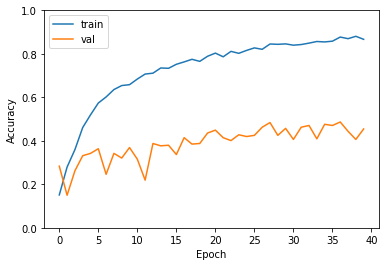

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

#### Results Model V01

### 5.2.2 Model V02 - Model with regularization, Batch normalization and double Dense layer

In [ ]:
# Architecture definition V02
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [ ]:
# COMPILE THE MODEL
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
history = net.fit(train_dataset, epochs=40, validation_data = test_dataset)

<IPython.core.display.Javascript object>

Epoch 1/40
63/63 [==============================] - 152s 2s/step - loss: 2.0911 - accuracy: 0.4202 - val_loss: 2.6330 - val_accuracy: 0.2032
Epoch 2/40
63/63 [==============================] - 150s 2s/step - loss: 1.4108 - accuracy: 0.5928 - val_loss: 1.9250 - val_accuracy: 0.3102
Epoch 3/40
63/63 [==============================] - 152s 2s/step - loss: 1.1655 - accuracy: 0.6766 - val_loss: 1.8387 - val_accuracy: 0.3930
Epoch 4/40
63/63 [==============================] - 153s 2s/step - loss: 1.0295 - accuracy: 0.7241 - val_loss: 1.9279 - val_accuracy: 0.4011
Epoch 5/40
63/63 [==============================] - 153s 2s/step - loss: 0.8984 - accuracy: 0.7745 - val_loss: 1.6479 - val_accuracy: 0.5160
Epoch 6/40
63/63 [==============================] - 150s 2s/step - loss: 0.8114 - accuracy: 0.8114 - val_loss: 2.2183 - val_accuracy: 0.3690
Epoch 7/40
63/63 [==============================] - 152s 2s/step - loss: 0.7764 - accuracy: 0.8094 - val_loss: 2.1543 - val_accuracy: 0.3690
Epoch 8/40
63

<IPython.core.display.Javascript object>

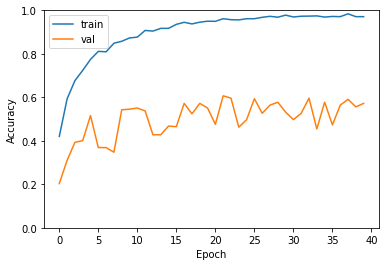

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

In [ ]:
# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 5]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

#### Results Model V02

### 5.2.3 Model V03 - Training the model with Data Agmentation from keras (regularization and dropout)

In [7]:
batch_size = 16
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255) 
####################################################à

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

test_generator = test_datagen.flow_from_directory(
    base_path_test,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

val_generator = val_datagen.flow_from_directory(
    base_path_val,
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


In [ ]:
# DEFINE AN EARLY STOPPING CRITERION
# callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights = True)

In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V03
inputs = keras.Input((224,224,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# ADD FLATTEN LAYER
x = tf.keras.layers.Flatten()(x)
# ADD DROPOUT LAYER
x = keras.layers.Dropout(.15)(x)

x = keras.layers.Dense(512, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net = keras.Model(inputs, outputs)

In [ ]:
# COMPILE THE MODEL
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# FIT THE MODEL
history = net.fit(train_generator, 
                  validation_data = val_generator, # test_generator
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = val_generator.n // val_generator.batch_size, # test_generator
                  epochs=100)
                  # callbacks = [callback])

In [ ]:
# Iterazioni (numero al di sotto delle epoche) viene calcolato come shape del training (in termini di lunghezza)/numero di epoche.
# Esempio: se lunghezza di training è 1803 la si divide per batch size di 64 e si ottiene 28 iterazioni per epoca! --> to see all 
# the datapoints it need 28 iterations.

In [ ]:
# SHOW DIFFERENT TRAINING EPOCHS: USE 40/70/100 TRAINING EPOCHS AND SHOW/COMMENT THE RESULTS!
# UTILE PER CAPIRE STEPS PER EPOCH AND VALIDATION STEPS: https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator

In [ ]:
history.history

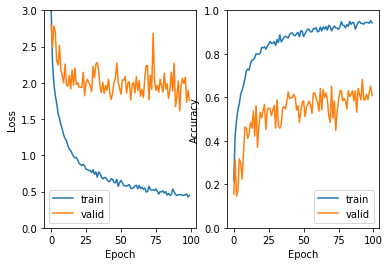

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

TO CHECK:

- https://cs230.stanford.edu/projects_fall_2019/reports/26233496.pdf
- http://www.warse.org/IJETER/static/pdf/file/ijeter38892020.pdf
- https://www.kdnuggets.com/2022/05/image-classification-convolutional-neural-networks-cnns.html
- https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

#### Results Model V03

EXAMPLE OF NOTES THAT YOU CAN ADD:

Note:

- The increased complexity does not appear to have improved the capability of the network.
- It has, however, impacted the validation accuracy curve, which is now converging faster.
- We will now address the current behavior to implement an early stopping mechanism.

Check the following:
- https://stackoverflow.com/questions/49017331/keras-flow-from-directorydirectory
- https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

RUN THE PREVIOUS CODE FOR ANOTHER 40 EPOCHS, THEN CONTINUE WITH THE REST

---------------------

### 5.2.4 MODEL V03.01 - Model from Keras

In [ ]:
# ARCHITECTURE FOUND AT: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
inputs = keras.Input((224,224,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# the model so far outputs 3D feature maps (height, width, features)

# FLATTEN AND ADD DROPOUT
x = tf.keras.layers.Flatten()(x) # this converts our 3D feature maps to 1D feature vectors
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(.20)(x)
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net = keras.Model(inputs, outputs)

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
history = net.fit(
    train_generator,
    steps_per_epoch= train_generator.n // train_generator.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps= val_generator.n // val_generator.batch_size)

# model_keras.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/100
112/112 [==============================] - 136s 1s/step - loss: 2.7998 - accuracy: 0.4555 - val_loss: 3.9889 - val_accuracy: 0.0469
Epoch 2/100
112/112 [==============================] - 134s 1s/step - loss: 2.0931 - accuracy: 0.6279 - val_loss: 3.0080 - val_accuracy: 0.2344
Epoch 3/100
112/112 [==============================] - 134s 1s/step - loss: 1.7741 - accuracy: 0.7180 - val_loss: 3.0519 - val_accuracy: 0.3490
Epoch 4/100
112/112 [==============================] - 144s 1s/step - loss: 1.5874 - accuracy: 0.7560 - val_loss: 2.5707 - val_accuracy: 0.4583
Epoch 5/100
112/112 [==============================] - 138s 1s/step - loss: 1.4959 - accuracy: 0.7577 - val_loss: 2.1596 - val_accuracy: 0.5781
Epoch 6/100
112/112 [==============================] - 135s 1s/step - loss: 1.3601 - accuracy: 0.7918 - val_loss: 2.1973 - val_accuracy: 0.5781
Epoch 7/100
112/112 [==============================] - 131s 1s/step - loss: 1.2946 - accuracy: 0.8069 - val_loss: 2.0946 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V03.0.1

### 5.2.5 Model V05 - Cross validation

Here you use only the train/test and not validation! That's because the cross validation procedure already takes a validation set in consideration!

In [ ]:
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#### Creating path dataframe

In [ ]:
# use Path object to grab all the images in a folder
caesar_salad_dir  = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/caesar_salad")
caprese_salad_dir = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/caprese_salad")
french_fries_dir  = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/french_fries")
greek_salad_dir   = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/greek_salad")
hamburger_dir     = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/hamburger")
hot_dog_dir       = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/hot_dog")
pizza_dir         = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/pizza")
sashimi_dir       = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/sashimi")
sushi_dir         = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/sushi")

In [ ]:
def generate_df(image_dir, label): 
  # get all the filepath. Convert to string for using flow_from_dataframe later
  filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name="Filepath").astype(str) # name: give the Series a name
  # labels
  labels = pd.Series(label, name="Label", index=filepaths.index)
  # concatenate two series as a dataframe
  df = pd.concat([filepaths, labels], axis=1)

  return df

In [ ]:
caesar_salad_df  = generate_df(caesar_salad_dir,  label="CAESAR_SALAD")
caprese_salad_df = generate_df(caprese_salad_dir, label="CAPRESE_SALAD")
french_fries_df  = generate_df(french_fries_dir,  label="FRENCH_FRIES")
greek_salad_df   = generate_df(greek_salad_dir,   label="GREEK_SALAD")
hamburger_df     = generate_df(hamburger_dir,     label="HAMBURGER")
hot_dog_df       = generate_df(hot_dog_dir,       label="HOT_DOG")
pizza_df         = generate_df(pizza_dir,         label="PIZZA")
sashimi_df       = generate_df(sashimi_dir,       label="SASHIMI")
caesar_salad_df  = generate_df(caesar_salad_dir,  label="CAESAR_SALAD")
sushi_df         = generate_df(sushi_dir,         label="SUSHI")

In [ ]:
all_df = pd.concat([caesar_salad_df,
                    caprese_salad_df,
                    french_fries_df,
                    greek_salad_df,
                    hamburger_df,
                    hot_dog_df,
                    pizza_df,
                    sashimi_df,
                    caesar_salad_df,
                    sushi_df], 
                   axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True) 
                   # sample and shuffle at the same time and reset index to have the correct values.
                   # drop the previous index so you do not have another column for that.

# problems:
#   - indeces are wrong
#   - the label are on top of each other and not shuffled
all_df

,Filepath,Label
0,/content/gdrive/MyDrive/Data_Science_2020-2022...,SUSHI
1,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
2,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
3,/content/gdrive/MyDrive/Data_Science_2020-2022...,HAMBURGER
4,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
...,...,...
999,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
1000,/content/gdrive/MyDrive/Data_Science_2020-2022...,FRENCH_FRIES
1001,/content/gdrive/MyDrive/Data_Science_2020-2022...,SUSHI
1002,/content/gdrive/MyDrive/Data_Science_2020-2022...,GREEK_SALAD


In [ ]:
Y_kfold = all_df[['Label']]

# kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED_VALUE) 

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen_CV = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=1,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

It can be seen, that the validation_split argument is not given any value as we will be creating the validation set using one of the k splits.

We also need to save the best model in each fold.

Auxiliary function for getting model name in each of the k iterations

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

Getting the folds and creating the data generators.

In [ ]:
train_data_generator = train_datagen_CV.flow_from_directory(
    base_path_train,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

test_data_generator = train_datagen_CV.flow_from_directory(
    base_path_test,
    target_size=(224,224),
    batch_size=32,
    shuffle=False,
    seed = SEED_VALUE,
    class_mode = "categorical")
	
# CREATE NEW MODEL
# DEFINE A SEQUENTIAL MODEL
def create_new_model(lr=0.001):
  model = tf.keras.models.Sequential([
  keras.Input((224, 224, 3)),

  # 1st Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("relu"),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 2nd Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation("relu"),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 3rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("relu"),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 4rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation("relu"),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # the model so far outputs 3D feature maps (height, width, features)

  # FLATTEN AND ADD DROPOUT
  keras.layers.Flatten(), # this converts our 3D feature maps to 1D feature vectors
  keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation("relu"),
  keras.layers.Dropout(.20),
  keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))

  ])

  return model

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.


In [ ]:
SAVED_MODELS = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed/saved_models/"

In [ ]:
from os import mkdir
from collections import defaultdict
# CREATE A DIRECTORY FOR THE PROCESSED IMAGES
try:
    os.mkdir(SAVED_MODELS)
except:
    print("Folder already found.")

Folder already found.


In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
all_history = {}

save_dir = SAVED_MODELS
fold_var = 1

for train_index, val_index in skf.split(np.zeros(len(all_df)), Y_kfold):
  print("fold_var number is:", fold_var)
  # print("train_index:", train_index)
  # print("val_index:", val_index)

  # EXPLAIN BETTER HOW THIS IS WORKING! CAN YOU ENSURE THAT THIS IS THE 
  # SAME SPLITTING DONE BEFORE? HOW DOES THIS SPLITTING WORKS?
  # training_data = all_df.iloc[train_index]
  # validation_data = all_df.iloc[val_index]

  # print("training_data", training_data)
  # print("validation_data", validation_data)
	 
  model_instance = create_new_model()
	# COMPILE NEW MODEL
  model_instance.compile(loss=keras.losses.categorical_crossentropy, 
                         optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                         metrics=['accuracy'])
	
	# CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      save_dir+get_model_name(fold_var), 
      monitor='val_accuracy', 
      verbose=1, 
      save_best_only=True, 
      mode='max')
 
  callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	#########################################
  # INSERT THE LOOP FOR THE PARAMETERS    #
  #########################################

  # LEGGI: https://stackoverflow.com/questions/47279677/how-use-grid-search-with-fit-generator-in-keras
  # LEGGI: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
  # LEGGI: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

  # def try_fit(learn_rate):
  #   history_page=[]
  #   for lr in learn_rate:
  #     # for moment in momentum:
  #     model_instance = create_new_model(lr)
  #     model_instance.compile(loss=keras.losses.categorical_crossentropy, 
  #                       optimizer=keras.optimizers.Adam(learning_rate=lr), 
  #                       metrics=['accuracy'])
  #     history = model_instance.fit_generator(
  #         train_generator,
  #         epochs=5,
  #         validation_data = test_generator,
  #         steps_per_epoch = train_generator.n // train_generator.batch_size,
  #         validation_steps = test_generator.n // test_generator.batch_size)    
        
  #     history_page.append(history)
    
  #   return history_page

  # for param in param_list:
  #   history_page = try_fit(learn_rate)
  #   history_page[0].history['accuracy']

  #########################################
  #                                       #
  #########################################
  
  # FIT THE MODEL
  history_CV = model_instance.fit(train_data_generator,
			    epochs=100,
			    callbacks=callbacks_list,
			    validation_data=test_data_generator)

  all_history[f'history-fold-{fold_var}'] = history_CV.history


	#PLOT HISTORY
	#		:
	#		:
	# PROVA A SALVARE LA HISTORY COME è STATO FATTO QUI --> SICURAMENTE MEGLIO!
  # https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554
  # https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

	# LOAD BEST MODEL to evaluate the performance of the model
  model_instance.load_weights(f"/{SAVED_MODELS}/model_"+str(fold_var)+".h5")
	
  results = model_instance.evaluate(test_data_generator)
  results = dict(zip(model_instance.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
	
  tf.keras.backend.clear_session()
	
  fold_var += 1

fold_var number is: 1
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 2.9982 - accuracy: 0.4049
Epoch 1: val_accuracy improved from -inf to 0.29032, saving model to /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed/saved_models/model_1.h5
57/57 [==============================] - 569s 10s/step - loss: 2.9982 - accuracy: 0.4049 - val_loss: 3.0298 - val_accuracy: 0.2903
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 2.1140 - accuracy: 0.6323
Epoch 2: val_accuracy did not improve from 0.29032
57/57 [==============================] - 122s 2s/step - loss: 2.1140 - accuracy: 0.6323 - val_loss: 3.7335 - val_accuracy: 0.1161
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 1.8008 - accuracy: 0.7249
Epoch 3: val_accuracy did not improve from 0.29032
57/57 [==============================] - 121s 2s/step - loss: 1.8008 - accuracy: 0.7249 - 

KeyboardInterrupt: ignored

USE THIS:
CONVERT IMAGEDATAGENERATOR AS NUMPY ARRAY AND FEED THEM INSIDE GRIDSEARCHCV AS X AND Y:
- https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array

FOLLOWING THEN:
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

CHECK:
- https://stackoverflow.com/questions/47279677/how-use-grid-search-with-fit-generator-in-keras
- https://stackoverflow.com/questions/59023969/grid-search-hyperparameters-for-an-image-classification-model
- https://stackoverflow.com/questions/54078455/grid-search-with-gridsearchcv-scikit-learn-hyperparameter-tuning-using-image

CONVERT IMAGES TO ARRAYS
- https://www.quora.com/How-do-I-load-train-and-test-data-from-the-local-drive-for-a-deep-learning-Keras-model

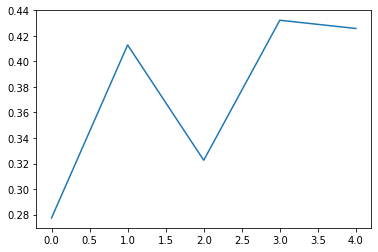

In [ ]:
plt.plot(VALIDATION_ACCURACY)

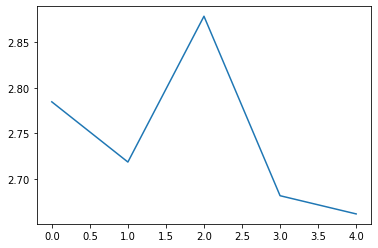

In [ ]:
plt.plot(VALIDATION_LOSS)

In [ ]:
all_history.values()

dict_values([{'loss': [3.6216585636138916, 2.5981621742248535, 2.2140607833862305, 2.0119338035583496, 1.8069442510604858], 'accuracy': [0.26012203097343445, 0.4409317672252655, 0.5330005288124084, 0.5773710608482361, 0.6289517283439636], 'val_loss': [3.214730739593506, 3.060303211212158, 2.9301836490631104, 2.8610901832580566, 2.784550905227661], 'val_accuracy': [0.1806451678276062, 0.21935483813285828, 0.26451611518859863, 0.2709677517414093, 0.2774193584918976]}, {'loss': [3.4453530311584473, 2.568146228790283, 2.193359613418579, 1.935943365097046, 1.7505513429641724], 'accuracy': [0.24736550450325012, 0.4315030574798584, 0.5219079256057739, 0.5901275873184204, 0.6317248940467834], 'val_loss': [3.163815975189209, 2.9759769439697266, 2.865057945251465, 2.720505952835083, 2.6555404663085938], 'val_accuracy': [0.18709677457809448, 0.20645160973072052, 0.3612903356552124, 0.42580646276474, 0.40645161271095276]}, {'loss': [3.7552313804626465, 2.735039234161377, 2.3069467544555664, 2.0152

Cerca online anche altre architetture di CNN differenti e aumenta deepness dell'architettura per arrivare almeno a 10 layers!

- https://towardsdatascience.com/image-classification-with-convolutional-neural-networks-12a7b4fb4c91

Altro tipo di architettura:
- https://www.kdnuggets.com/2022/05/image-classification-convolutional-neural-networks-cnns.html

Try:

- https://medium.com/codex/how-to-tune-hyperparameters-for-better-neural-network-performance-b8f542855d2e
- https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554
- https://medium.com/@navmcgill/k-fold-cross-validation-in-keras-convolutional-neural-networks-835bed559d04

Instead of Max pooling, you can also use fractional pooling:

https://stackoverflow.com/questions/44991470/using-tensorflow-layers-in-keras

Check the paper:
Efficient Processing DNN a tutorial and survery, page 10 for reference.

#### Results Model V05

### 5.2.6 Model V06 - GRIDSEARCH

Ottima spiegazione:

- https://stackoverflow.com/questions/49160206/does-gridsearchcv-perform-cross-validation

- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/#:~:text=Using%20Dropout%20on%20Hidden%20Layers,layer%20and%20the%20output%20layer.

Non stare ad applicare anche la cross validation, ma fai direttamente GRIDSEARCHCV che tiene in consideraziona ANCHE la cross validation!

Attenzione: "As you proceed through the examples in this post, you will aggregate the best parameters. This is not the best way to grid search because parameters can interact, but it is good for demonstration purposes." Based on this comment, you should create a single hypertuning parameter model because the parameters can interact between each others. O, altrimenti, potresti anche provarli uno per uno e poi spiegare che lßappendimento era troppo lungo per poter essere processato in una volta sola in Colab perche la macchina si disconnetteva (ci sono soluzioni a parte pagare?) 

#### Parameters tuning

In [ ]:
itr = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(224,224),
    batch_size=1803, # you flow through the entire training dataset and get all the images, using just one batch size!
    class_mode='categorical')

X, y = itr.next()

Found 1803 images belonging to 9 classes.


- https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array

In [ ]:
def create_GSCV_model(lr=0.001, init_mode="he_uniform", activation = "relu", dropout_rate=0.0):
  model_gridsearchCV = tf.keras.models.Sequential([
  keras.Input((224, 224, 3)),

  # 1st Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 2nd Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 3rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 4rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # the model so far outputs 3D feature maps (height, width, features)

  # FLATTEN AND ADD DROPOUT
  keras.layers.Flatten(), # this converts our 3D feature maps to 1D feature vectors
  keras.layers.Dropout(0.25),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation('relu'),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))
  ])

  # COMPILE THE MODEL
  model_gridsearchCV.compile(loss=keras.losses.categorical_crossentropy,
                             optimizer= keras.optimizers.Adam(learning_rate=lr),
                             metrics=['accuracy'])

  return model_gridsearchCV

In [ ]:
# CREATE THE MODEL
# model_gridsearchcv = KerasClassifier(model=model_gridsearchCV, epochs=20, verbose=10)
model_gridsearchcv = KerasClassifier(model=create_GSCV_model(), epochs=20, verbose=10)

In [ ]:
# DEFINE THE GRID SEARCH PARAMETERS
batch_size = [32, 64, 128]
optimizer = ['SGD', 'RMSprop', 'Adam']
lr = [0.1, 0.01, 0.001]
# momentum = [0.0, 0.2, 0.4]
# activation = ['softmax', 'relu', 'LeakyRelu']
# init_mode = ['uniform', 'lecun_uniform', 'he_uniform']
# dropout_rate = [0.0, 0.1, 0.2] 

# CREATE THE PARAM GRID
param_grid_CV = dict(batch_size = batch_size, 
                  optimizer = optimizer, 
                  optimizer__learning_rate = lr)
                  # optimizer__momentum = momentum,
                  # model__activation = activation)
                  # model__dropout_rate = dropout_rate)
                  # model__init_mode=init_mode)

# DEFINE THE GRIDSEARCHCV METHOD
# grid_cv = GridSearchCV(estimator=model_gridsearchcv, param_grid=param_grid, n_jobs = 1, cv=3, error_score="raise")
grid_cv = RandomizedSearchCV(estimator = model_gridsearchcv, 
                             param_distributions = param_grid_CV, 
                             n_jobs = 1, 
                             cv = 3, 
                             error_score = "raise")

grid_cv

In [ ]:
# FIT THE GRIDSEARCH MODEL
grid_fit = grid_cv.fit(X, y)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [ ]:
# SUMMARIZE RESULTS

print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))
means = grid_fit.cv_results_['mean_test_score']
stds = grid_fit.cv_results_['std_test_score']
params = grid_fit.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.799224 using {'optimizer__learning_rate': 0.01, 'optimizer': 'RMSprop', 'batch_size': 32}
0.550194 (0.015746) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64}
0.236273 (0.014119) with: {'optimizer__learning_rate': 0.01, 'optimizer': 'SGD', 'batch_size': 128}
0.782585 (0.029338) with: {'optimizer__learning_rate': 0.001, 'optimizer': 'SGD', 'batch_size': 32}
0.602884 (0.090182) with: {'optimizer__learning_rate': 0.01, 'optimizer': 'SGD', 'batch_size': 64}
0.530782 (0.046011) with: {'optimizer__learning_rate': 0.001, 'optimizer': 'RMSprop', 'batch_size': 64}
0.214642 (0.031335) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'RMSprop', 'batch_size': 128}
0.505824 (0.054189) with: {'optimizer__learning_rate': 0.001, 'optimizer': 'SGD', 'batch_size': 64}
0.777593 (0.025136) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'SGD', 'batch_size': 32}
0.799224 (0.021666) with: {'optimizer__learning_rate': 0.01, 'optimizer': 'RMSprop', 'batch_size

In [ ]:
# ALTRO MODO DI FITTARE:
# grid_result_history = grid_cv.fit(X, y, # test_generator
#                        steps_per_epoch = train_generator.n // train_generator.batch_size,
#                        validation_steps = val_generator.n // val_generator.batch_size)# test_generator
#                        # callbacks = [callback])

#### Results Model V06



---



---



### 5.2.7 Model V04 - Transfer learning (and dropout)

USA QUESTO COME COMPARAZIONE:

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

- https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://pyimagesearch.com/2016/08/10/imagenet-classification-with-python-and-keras/

QUALE ARCHITETTURA?

MOBILENET OR RESNET? APPLICALE ENTRAMBE E COMPARA RISULTATI SU ALMENO 50 EPOCHE!
- https://www.tertiaryinfotech.com/comparing-pre-trained-resnet-and-mobilenet/

The goal of using a pretrained model is that this model has been built to be very good at extracting useful features from images (it is called _feature extractor_).
The all convolutional layer that is not meant to do classification (the last layer) has the goal of extracting features from the images.
We will use those features in order to classify our data.

(ESTENDERE QUESTA SPIEGAZIONE IN MANIERA MIGLIORE!)

##### MOBILENETV2

https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

Comparazione MOBILENETV2 e RESNET50:
- https://analyticsindiamag.com/mobilenet-vs-resnet50-two-cnn-transfer-learning-light-frameworks/

- https://www.tertiaryinfotech.com/comparing-pre-trained-resnet-and-mobilenet/

In [8]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=True, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model.trainable = False

14536120/14536120 [==============================] - 0s 0us/step


In [9]:
# ARCHITECTURE DEFINITION FOR MODEL V04 PRETRAINED ON IMAGENET
# inputs = pretrained_model.input


model_pretrained_mobilenetV2 = tf.keras.Sequential([
    pretrained_model, 
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dense(num_classes, 
                          activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ]
    )

########################################
# ADD DROPOUT
# x = keras.layers.Dropout(.1)(x)
# x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
# will be our classification result.
# For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
# outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# net = keras.Model(inputs, outputs)

In [10]:
print(model_pretrained_mobilenetV2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 9)                 9009      
                                                                 
Total params: 3,547,993
Trainable params: 9,009
Non-trainable params: 3,538,984
_________________________________________________________________
None


In [11]:
model_pretrained_mobilenetV2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
history_mobilenetV2 = model_pretrained_mobilenetV2.fit(train_generator, 
                  validation_data = test_generator, 
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = test_generator.n // test_generator.batch_size, 
                  epochs=30) #,
                  # callbacks = [callback])
                  
print("--- Training Completed ---")

Epoch 1/30
 74/112 [==================>...........] - ETA: 3:12 - loss: 2.2125 - accuracy: 0.1115

**Learning rate**
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

The amount that the weights are updated during training is referred to as the step size or the “learning rate.”

Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

The challenge of training deep learning neural networks involves carefully selecting the learning rate. It may be the most important hyperparameter for the model.

USEFUL LINKS:

BEST:
- https://medium.com/mlearning-ai/7-best-techniques-to-improve-the-accuracy-of-cnn-w-o-overfitting-6db06467182f
- https://sgugger.github.io/the-1cycle-policy.html

- https://www.paperspace.com/gradient/notebooks
- https://stats.stackexchange.com/questions/453221/should-i-use-gridsearchcv-on-all-of-my-data-or-just-the-training-set
- https://www.quora.com/What-kind-of-image-pre-processing-should-be-done-before-feeding-it-to-a-Convolutional-Neural-Network
- https://opt-ml.org/papers/2021/paper53.pdf
- https://towardsai.net/p/l/stop-using-grid-search-the-complete-practical-tutorial-on-keras-tuner
- https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_mobilenetV2.history['loss'])
plt.plot(history_mobilenetV2.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_mobilenetV2.history['accuracy'])
plt.plot(history_mobilenetV2.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
print("Max accuracy:", max(history_mobilenetV2.history['accuracy']))
print("Max val_accuracy:", max(history_mobilenetV2.history['val_accuracy']))

print()

print("Min loss:", min(history_mobilenetV2.history['loss']))
print("Min val_loss:", min(history_mobilenetV2.history['val_loss']))

###### Results Model V04 - MobileNetV2

#### RESNET50

https://medium.com/@nutanbhogendrasharma/image-classification-with-resnet50-model-12f4c79c216b#:~:text=keras%2Fmodels%2F.,other%20to%20form%20a%20network.

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model_resnet50 = tf.keras.applications.ResNet50(
    input_shape = (224, 224, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model_resnet50.trainable = False

In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V04 PRETRAINED ON IMAGENET

model_pretrained_resnet50 = tf.keras.Sequential([
    pretrained_model, 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, 
                          activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ]
    )

In [ ]:
print(model_pretrained_resnet50.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
model_pretrained_resnet50.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
history_resnet50 = model_pretrained_resnet50.fit(train_generator, 
                  validation_data = test_generator, 
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = test_generator.n // test_generator.batch_size, 
                  epochs=30) #,
                  # callbacks = [callback])

Epoch 1/30
112/112 [==============================] - 231s 2s/step - loss: 2.3727 - accuracy: 0.1058 - val_loss: 2.1891 - val_accuracy: 0.1458
Epoch 2/30
112/112 [==============================] - 237s 2s/step - loss: 2.2725 - accuracy: 0.1158 - val_loss: 2.1665 - val_accuracy: 0.3264
Epoch 3/30
112/112 [==============================] - 257s 2s/step - loss: 2.2518 - accuracy: 0.1253 - val_loss: 2.2194 - val_accuracy: 0.0347
Epoch 4/30
112/112 [==============================] - 230s 2s/step - loss: 2.2403 - accuracy: 0.1253 - val_loss: 2.2044 - val_accuracy: 0.0417
Epoch 5/30
112/112 [==============================] - 222s 2s/step - loss: 2.2018 - accuracy: 0.1528 - val_loss: 2.1858 - val_accuracy: 0.0694
Epoch 6/30
112/112 [==============================] - 227s 2s/step - loss: 2.2185 - accuracy: 0.1472 - val_loss: 2.1569 - val_accuracy: 0.0764
Epoch 7/30
112/112 [==============================] - 222s 2s/step - loss: 2.1886 - accuracy: 0.1477 - val_loss: 2.2001 - val_accuracy: 0.0417

SE I RISULTATI NON SONO BUONI è PERCHé LA RESNET è PIù GRANDE DELLA MOBILENETV2 CON MOLTI PIù PARAMETRI. CERFCA SE QUESTO POTREBBE ESSERE UN MOTIVO!

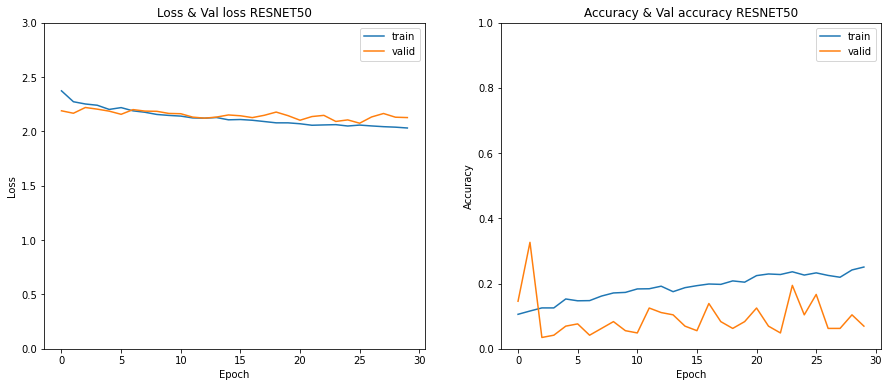

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss RESNET50")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy RESNET50")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

###### Results Model V04 - ResNet50

#### VGG16

In [8]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model_VGG16 = tf.keras.applications.vgg16.VGG16(
    input_shape = (224, 224, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model_VGG16.trainable = False

58889256/58889256 [==============================] - 5s 0us/step


In [9]:
# ARCHITECTURE DEFINITION FOR MODEL V04 PRETRAINED ON IMAGENET

pretrained_model_VGG16 = tf.keras.Sequential([
    pretrained_model_VGG16, 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, 
                          activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ]
    )

In [10]:
# VISULIZE THE SUMMARY
print(pretrained_model_VGG16.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 9)                 4617      
                                                                 
Total params: 14,719,305
Trainable params: 4,617
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [11]:
# COMPILE THE MODEL
pretrained_model_VGG16.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [12]:
# FIT THE MODEL
history_VGG16 = pretrained_model_VGG16.fit(train_generator, 
                  validation_data = test_generator, 
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = test_generator.n // test_generator.batch_size, 
                  epochs=30) #,
                  # callbacks = [callback])

print("--- Training Completed ---")

Epoch 1/30
112/112 [==============================] - 1635s 14s/step - loss: 2.4562 - accuracy: 0.1198 - val_loss: 2.4471 - val_accuracy: 0.0764
Epoch 2/30
112/112 [==============================] - 26s 234ms/step - loss: 2.2856 - accuracy: 0.1421 - val_loss: 2.2808 - val_accuracy: 0.1458
Epoch 3/30
112/112 [==============================] - 27s 241ms/step - loss: 2.2287 - accuracy: 0.1550 - val_loss: 2.1898 - val_accuracy: 0.1736
Epoch 4/30
112/112 [==============================] - 26s 235ms/step - loss: 2.1650 - accuracy: 0.1863 - val_loss: 2.1442 - val_accuracy: 0.2153
Epoch 5/30
112/112 [==============================] - 28s 247ms/step - loss: 2.1179 - accuracy: 0.2373 - val_loss: 2.1028 - val_accuracy: 0.2431
Epoch 6/30
112/112 [==============================] - 26s 234ms/step - loss: 2.0778 - accuracy: 0.2703 - val_loss: 2.0744 - val_accuracy: 0.2917
Epoch 7/30
112/112 [==============================] - 27s 236ms/step - loss: 2.0331 - accuracy: 0.3151 - val_loss: 2.0531 - val_ac

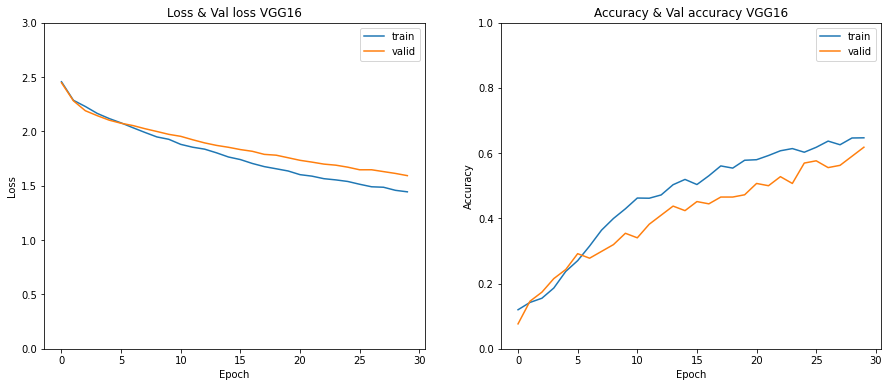

In [13]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss VGG16")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy VGG16")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

###### Results Model V04 - VGG16

Convergence much slower than MobileNetV2. Why? (for sure better than ResNet50. Why?)

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

# SPOSTARE: CROSS VALIDATION E GRIDSEARCHCV SOPRA! DEVONO STARE AL DI SOTTO DEI CUSTOM MODELS! UTILIZZA IPERPARAMETRI CHE HAI TROVATO IN GRIDSEARCH PER QUESTO ULTIMO MODELLO IN TERMINI DI TRANSFER LEARNING!

## 6.Bayesian Optimization for hyperparameters optimization

Automatic Hyperparameter Optimization With Keras Tuner:
https://blog.paperspace.com/hyperparameter-optimization-with-keras-tuner/

# 7.Evaluate and Test on the test data

Follow this:
- https://medium.com/@draj0718/image-classification-and-prediction-using-transfer-learning-3cf2c736589d

- https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817

- https://medium.com/@nutanbhogendrasharma/image-classification-with-resnet50-model-12f4c79c216b#:~:text=keras%2Fmodels%2F.,other%20to%20form%20a%20network.

In [ ]:
# itr = train_datagen.flow_from_directory(
#     base_path_test,
#     target_size=(224,224),
#     batch_size=1803, # you flow through the entire training dataset and get all the images, using just one batch size!
#     class_mode='categorical')

# X_test, y_test = itr.next()

In [ ]:
Y_pred = model_pretrained_mobilenetV2.predict(test_generator, test_generator.n // test_generator.batch_size)

val_preds = np.argmax(Y_pred, axis=1)
val_trues = test_generator.classes

# PRINT THE CLASSIFICATION REPORT
print(classification_report(val_trues, val_preds))

**Confusion Matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.

PRINT A HEATMAP AS A CONFUSION MATRIX

In [ ]:
Y_pred = model_pretrained_mobilenetV2.predict(test_generator, test_generator.n // test_generator.batch_size)

val_preds = np.argmax(Y_pred, axis=1)
val_trues = test_generator.classes

# PRINT THE CONFUSION MATRIX
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

# 8.Save the Model

In [ ]:
keras_file = "mobilenetV2.h5"
tf.keras.models.save_model(model_pretrained_mobilenetV2, keras_file) # MODIFY MODEL WITH YOUR OWN MODEL

The following section has to be implemented inside the Deployment notebook:

# 9.Prediction using new image

In [ ]:
# LOAD SAVED MODEL AND GET PATH FOR AN IMAGE
best_model = load_model("mobilenetV2.h5") 
img_path_pred = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/hot_dog/20160713_1218381.jpg_RESIZED.jpg" # GET A NEW IMAGE. IMPLEMENT THE SAME THING AS THE BOSCH PROJECT WHERE YOU HAD MULTIPLE RANDOM IMAGES

In [ ]:
# LOAD THE IMAGE
img_pred = image.load_img(img_path_pred, target_size=(224, 224))

In [ ]:
# SHOW THE IMAGE
img_read = cv2.imread(img_path_pred)
cv2_imshow(img_read)

In [ ]:
# CONVERT THE IMAGE TO ARRAY
x = image.img_to_array(img_pred)

# EXPAND DIMENSIONS
x = np.expand_dims(x, axis=0)

# PREPROCESS THE INPUT
x = preprocess_input(x)

preds = best_model.predict(x)

print(decode_predictions(preds, top=3)[0])

In [ ]:

# create a list containing the class labels
# class_labels = ["caesar_salad", 
#                 "caprese_salad", 
#                 "french_fries",
#                 "greek_salad",
#                 "hamburger",
#                 "hot_dog",
#                 "pizza",
#                 "sashimi",
#                 "sushi"]

class_labels = ["pizza",
"caprese_salad", 
"french_fries",
"sashimi",
"greek_salad",
"hamburger",
"hot_dog",
"sushi",
"caesar_salad", ]

# find the index of the class with maximum score
pred = np.argmax(preds, axis=-1)
print(pred)

# print the label of the class with maximum score
print(class_labels[pred[0]])
print(class_labels)

# 10.Results Analysis

# 11.Deploy in data app --> chek this out: https://dev.to/code_jedi/how-to-turn-your-python-machine-learning-code-into-a-web-app-2hfc

https://towardsdatascience.com/how-to-deploy-machine-learning-models-601f8c13ff45

https://www.youtube.com/watch?v=xl0N7tHiwlw

# 12.Future Work and Improvements

---------------------------

# Comments:


*   Considera, nella parte finale, di aumentare le immagini ad almeno 1000 per classe (se non addirittura a 2000/3000)



# Prova a cross validare con questo modello, vedi se ottieni risultati migliori!

- https://stackoverflow.com/questions/62341053/validation-accuracy-not-improving

# RICORDATI: pip freeze to list the out the packages installed in your environment: